In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-05-05 16:12:15.344374: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 16:12:15.367802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 16:12:15.478879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 16:12:15.479570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 16:12:16.148462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
np.random.seed(33)

In [2]:
wireplane = "V"
path = 'processed_data/'
filenames = [path+f for f in listdir(path) if (isfile(join(path, f)) and wireplane in f)]
filenames

['processed_data/y_test_AE_V.npy',
 'processed_data/y_train_ROI_V.npy',
 'processed_data/y_test_ROI_V.npy',
 'processed_data/x_test_V.npy',
 'processed_data/y_train_AE_V.npy',
 'processed_data/x_train_V.npy']

In [3]:
x_train = np.load(path+'x_train_' + wireplane + '.npy')
x_test = np.load(path+'x_test_' + wireplane + '.npy')
y_train = np.load(path+'y_train_ROI_' + wireplane + '.npy')
y_test = np.load(path+'y_test_ROI_'+wireplane+'.npy')

In [4]:
print(x_test.shape, y_train.shape, y_test.shape, y_train.shape)

(100000, 200) (100000,) (100000,) (100000,)


In [5]:
#split train and valid sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(80000, 200) (80000,)
(100000, 200) (100000,)
(20000, 200) (20000,)


In [7]:
mean = x_train.mean()
std = x_train.std()

In [8]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std

In [9]:
np.save("ROI_models/mean_"+wireplane+"_nu_ROI", mean)
np.save("ROI_models/scale_"+wireplane+"_nu_ROI", std)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [11]:
time_periods = 200
def create_model():
    model = Sequential()  
    #first convolutional block
    model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
    model.add(MaxPooling1D(pool_size=2))

    #second convolutional block
    model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))

    #forth convolutional block                                      
    model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2)) 

    model.add(Flatten())



    model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
    return model

In [12]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

In [13]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [14]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(80000, 200, 1) (20000, 200, 1) (100000, 200, 1)


In [15]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [16]:
#%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
40/40 [==============================] - 2s 28ms/step - loss: 0.5223 - accuracy: 0.7001 - val_loss: 0.3551 - val_accuracy: 0.8666
Epoch 2/100
40/40 [==============================] - 1s 22ms/step - loss: 0.3207 - accuracy: 0.8698 - val_loss: 0.2805 - val_accuracy: 0.8882
Epoch 3/100
40/40 [==============================] - 1s 19ms/step - loss: 0.2913 - accuracy: 0.8815 - val_loss: 0.2687 - val_accuracy: 0.8932
Epoch 4/100
40/40 [==============================] - 1s 22ms/step - loss: 0.2825 - accuracy: 0.8864 - val_loss: 0.2637 - val_accuracy: 0.8959
Epoch 5/100
40/40 [==============================] - 1s 19ms/step - loss: 0.2775 - accuracy: 0.8887 - val_loss: 0.2631 - val_accuracy: 0.8964
Epoch 6/100
40/40 [==============================] - 1s 20ms/step - loss: 0.2752 - accuracy: 0.8900 - val_loss: 0.2602 - val_accuracy: 0.8963
Epoch 7/100
40/40 [==============================] - 1s 21ms/step - loss: 0.2726 - accuracy: 0.8906 - val_loss: 0.2571 - val_accuracy: 0.8990
Epoch 

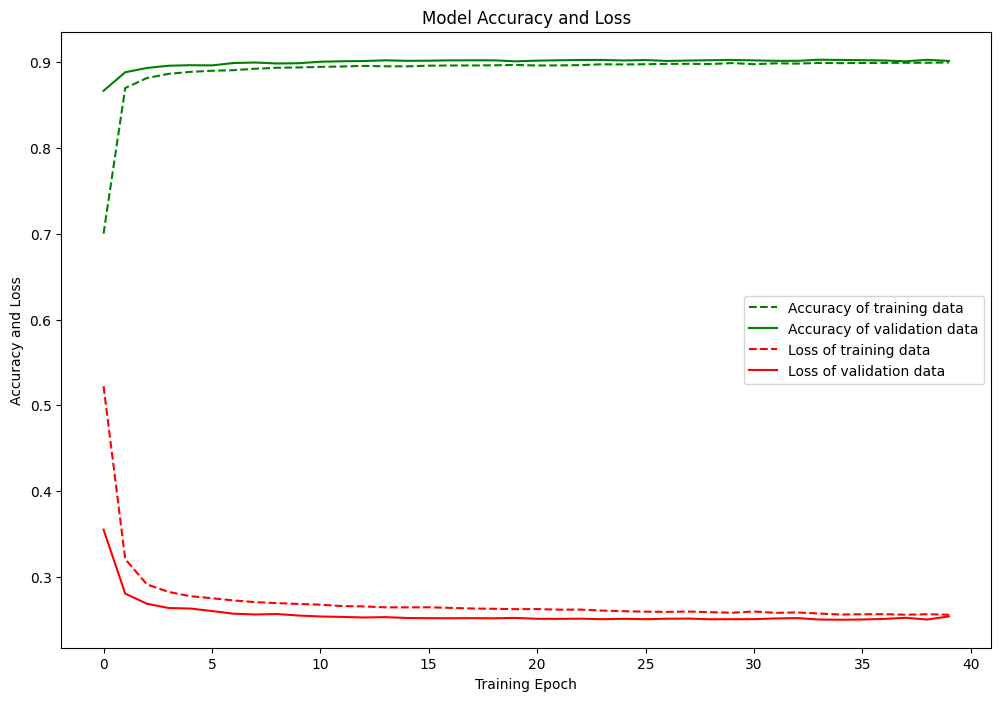

In [17]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [18]:
#del x_train

import gc
gc.collect()

5932

In [19]:
model.save("ROI_models/model_" + wireplane + "plane_nu_ROI.h5")

In [20]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

25/25 [==============================] - 0s 11ms/step - loss: 0.2588 - accuracy: 0.8983


[0.2588192820549011, 0.8983100056648254]

In [21]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [25]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=1024)

79/79 [==============================] - 0s 4ms/step
CPU times: user 947 ms, sys: 33.7 ms, total: 981 ms
Wall time: 464 ms


<Axes: >

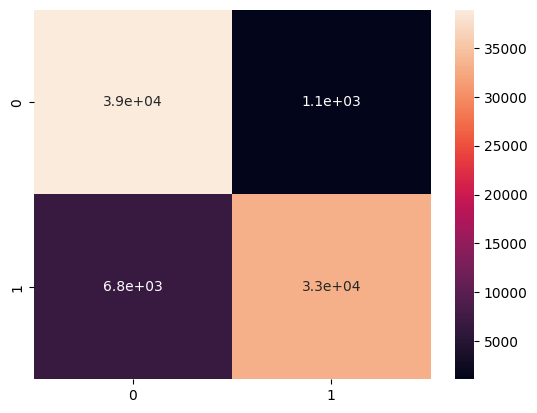

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<Axes: >

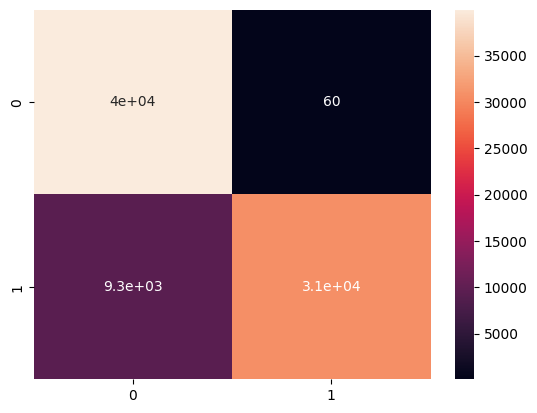

In [27]:
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

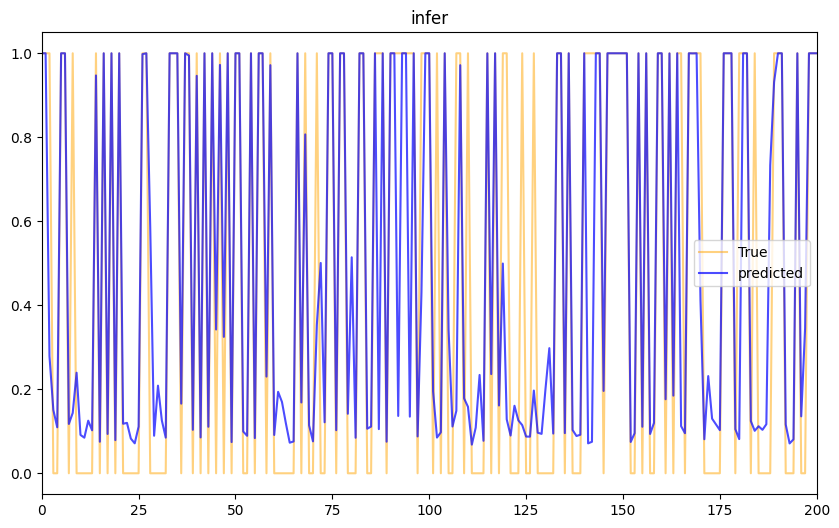

In [28]:
start_for_plot = 0
fig = plt.figure(figsize=(10,6))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [30]:
print(auc_keras)

0.9435142254576232


In [31]:
np.save("ROI_results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("ROI_results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("ROI_results/thresholds_" + wireplane + "_train", thresholds_keras)

# Valid

In [32]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

5/5 [==============================] - 0s 12ms/step
CPU times: user 255 ms, sys: 5.25 ms, total: 261 ms
Wall time: 104 ms


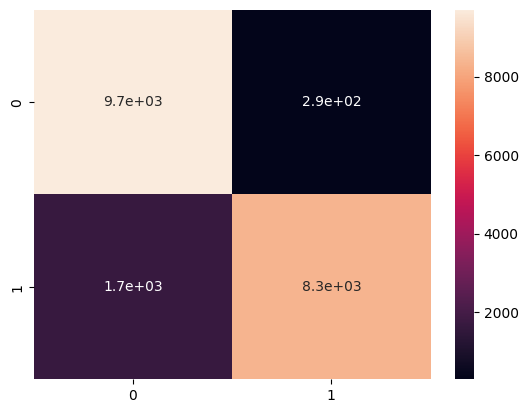

In [33]:
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<Axes: >

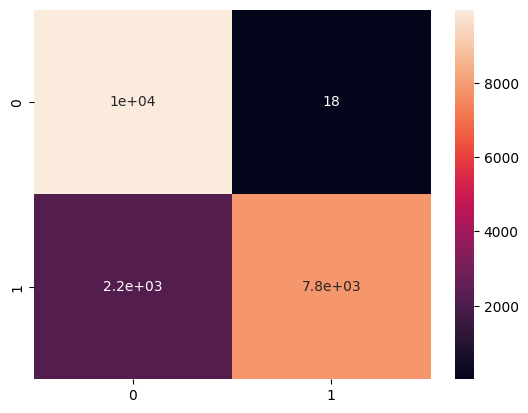

In [34]:
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

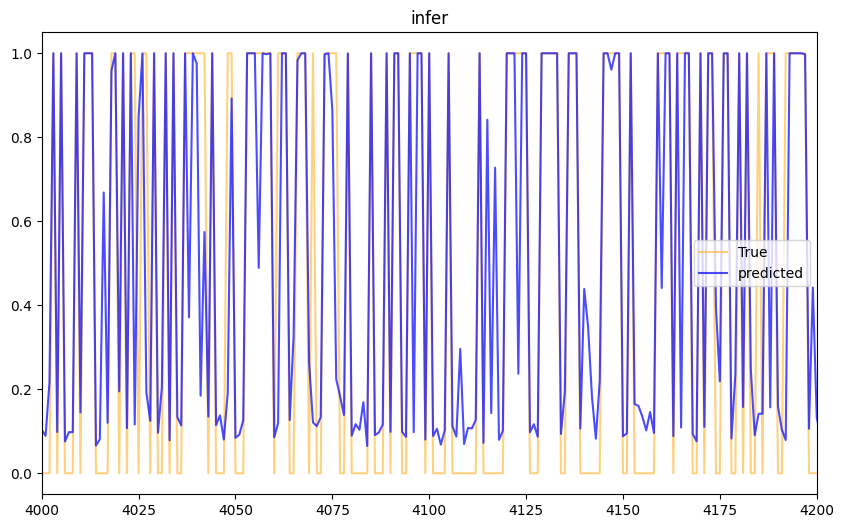

In [35]:
start_for_plot = 4000
fig = plt.figure(figsize=(10,6))
plt.plot(y_valid_,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [36]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.9425626618557044


In [37]:
np.save("ROI_results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("ROI_results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("ROI_results/thresholds_" + wireplane + "_valid", thresholds_keras)

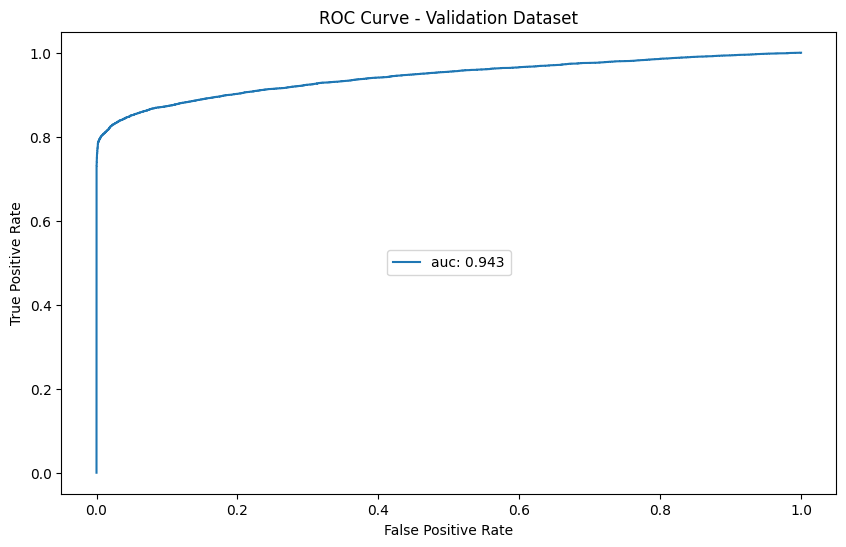

In [38]:
fig = plt.figure(figsize=(10,6))
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc_keras,3)))
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

# test

In [39]:
#%%time
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


25/25 [==============================] - 0s 11ms/step


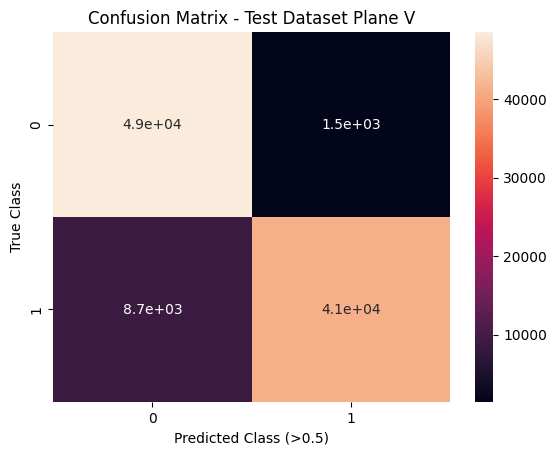

In [40]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

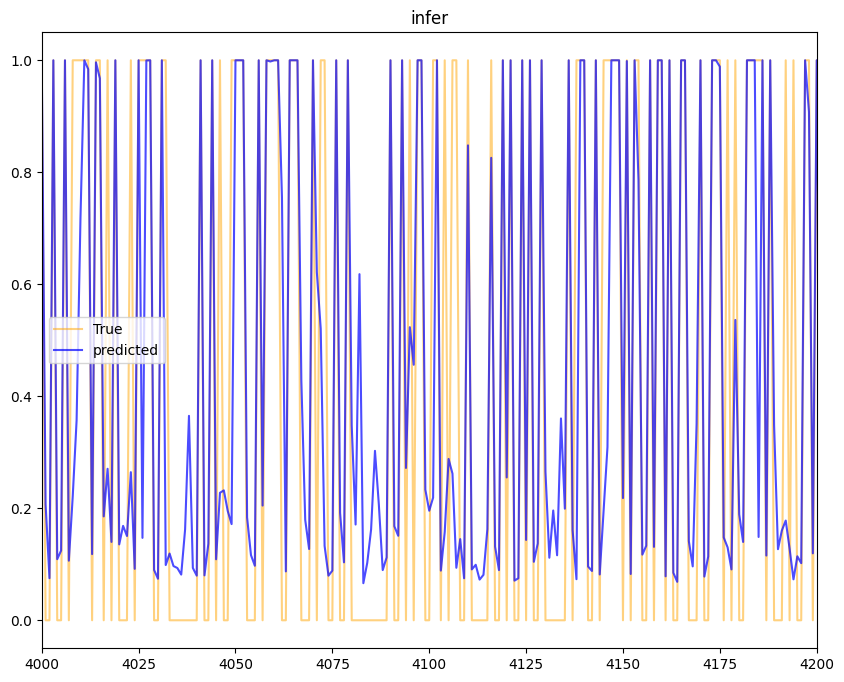

In [41]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

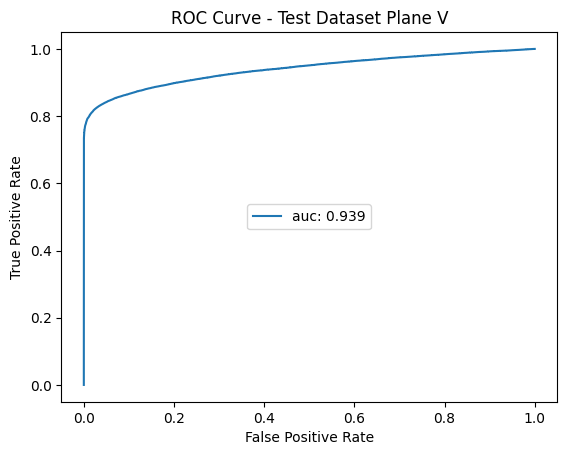

In [42]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [43]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

13/13 [==============================] - 0s 11ms/step
CPU times: user 1.14 s, sys: 56.6 ms, total: 1.2 s
Wall time: 440 ms


(array([1.0000e+00, 1.6251e+04, 1.8205e+04, 6.4710e+03, 3.0840e+03,
        1.7250e+03, 1.1200e+03, 7.1600e+02, 5.4500e+02, 4.1800e+02,
        2.9800e+02, 2.1500e+02, 2.0500e+02, 1.6600e+02, 1.5900e+02,
        1.1500e+02, 9.3000e+01, 9.1000e+01, 7.8000e+01, 4.4000e+01]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

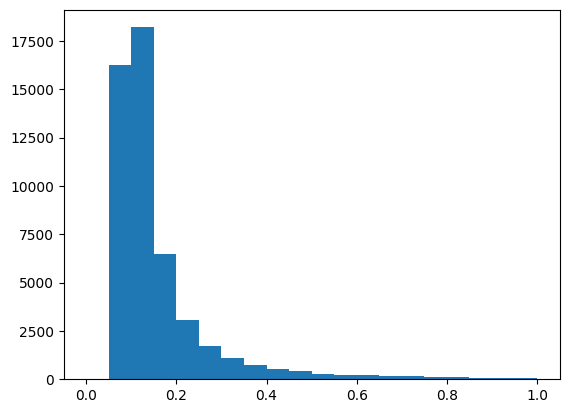

In [44]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

(array([    0.,  1391.,  2475.,  1504.,   932.,   681.,   541.,   431.,
          386.,   364.,   332.,   323.,   323.,   344.,   316.,   392.,
          432.,   504.,   749., 37580.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

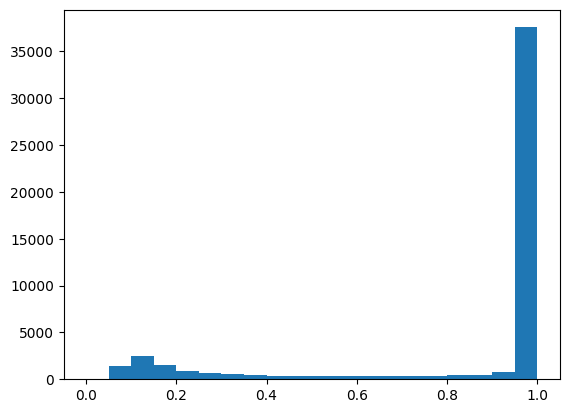

In [45]:
plt.hist(all_infer_signal, range = (0,1), bins=20)